# Comparando los sdes

In [ ]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# Cargar los datos del archivo JSON
json_file_path = 'resultados_sdes_CIFAR10.json'
try:
    with open(json_file_path, 'r') as f:
        all_models_data = json.load(f)
except FileNotFoundError:
    print(f"Error: El archivo '{json_file_path}' no fue encontrado.")
    exit()
except json.JSONDecodeError:
    print(f"Error: El archivo '{json_file_path}' no tiene un formato JSON válido.")
    exit()

epoch_limit = 50
plt.style.use('seaborn-v0_8-whitegrid') # Estilo agradable

In [2]:
# --- 1. Preparar los datos ---
model_names = list(all_models_data.keys())
processed_data = {}
all_losses_for_boxplot = []
model_labels_for_boxplot = []
final_losses = {}
average_losses = {}

for model_name, loss_dict_str_keys in all_models_data.items():
    epochs = []
    losses = []
    current_model_losses_up_to_limit = []

    # Convertir claves de época a int y filtrar hasta epoch_limit
    loss_dict_int_keys = {}
    for epoch_str, loss_val in loss_dict_str_keys.items():
        try:
            loss_dict_int_keys[int(epoch_str)] = float(loss_val)
        except ValueError:
            print(f"Advertencia: Valor no numérico para época '{epoch_str}' o loss '{loss_val}' en modelo '{model_name}'. Se omitirá.")
            continue

    sorted_epochs = sorted(loss_dict_int_keys.keys())

    last_epoch_for_model = 0
    for epoch_num in sorted_epochs:
        if epoch_num <= epoch_limit:
            loss_val = loss_dict_int_keys[epoch_num]
            epochs.append(epoch_num)
            losses.append(loss_val)
            current_model_losses_up_to_limit.append(loss_val)
            last_epoch_for_model = epoch_num
        else:
            break # Detenerse si se supera el límite de épocas

    if epochs: # Solo procesar si hay datos hasta la época límite
        processed_data[model_name] = {'epochs': epochs, 'losses': losses}
        all_losses_for_boxplot.extend(current_model_losses_up_to_limit)
        model_labels_for_boxplot.extend([model_name] * len(current_model_losses_up_to_limit))
        if losses: # Asegurarse que hay losses para calcular final y promedio
             # Usar el loss de la última época disponible hasta el epoch_limit
            final_losses[model_name] = loss_dict_int_keys.get(last_epoch_for_model, np.nan) if last_epoch_for_model > 0 else np.nan
            average_losses[model_name] = np.mean(current_model_losses_up_to_limit) if current_model_losses_up_to_limit else np.nan
    else:
        print(f"Advertencia: El modelo '{model_name}' no tiene datos hasta la época {epoch_limit} o antes.")
        final_losses[model_name] = np.nan
        average_losses[model_name] = np.nan


C:\Users\loren\AppData\Local\Temp\ipykernel_16740\369081835.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(processed_data)) # Un color diferente para cada modelo


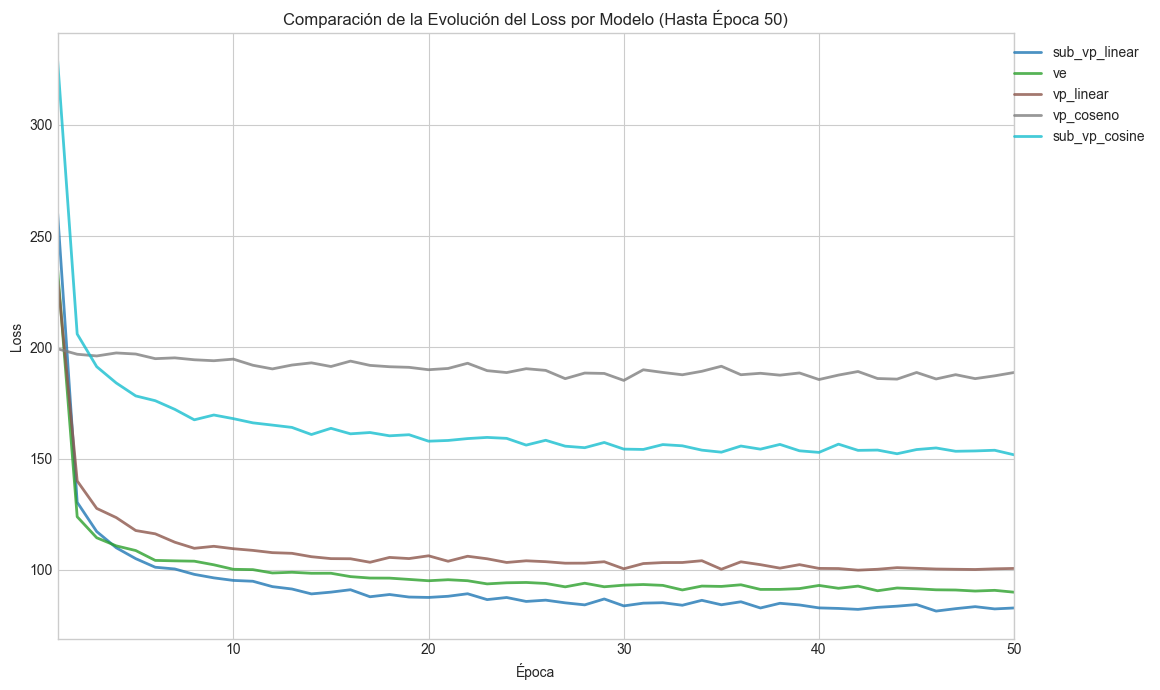

In [3]:

# --- 2. Gráfica de Líneas Comparativa ---
plt.figure(figsize=(14, 7))
colors = plt.cm.get_cmap('tab10', len(processed_data)) # Un color diferente para cada modelo

for i, (model_name, data) in enumerate(processed_data.items()):
    if data['epochs']: # Solo graficar si hay datos
        plt.plot(data['epochs'], data['losses'], label=model_name, color=colors(i), alpha=0.8, linewidth=2)

plt.title(f'Comparación de la Evolución del Loss por Modelo (Hasta Época {epoch_limit})')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)
plt.xlim(1, epoch_limit) # Asegurar que el eje x no se extienda más allá
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Ajustar para la leyenda fuera
plt.show()

C:\Users\loren\AppData\Local\Temp\ipykernel_16740\663335620.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='Loss', data=df_boxplot, palette='pastel')


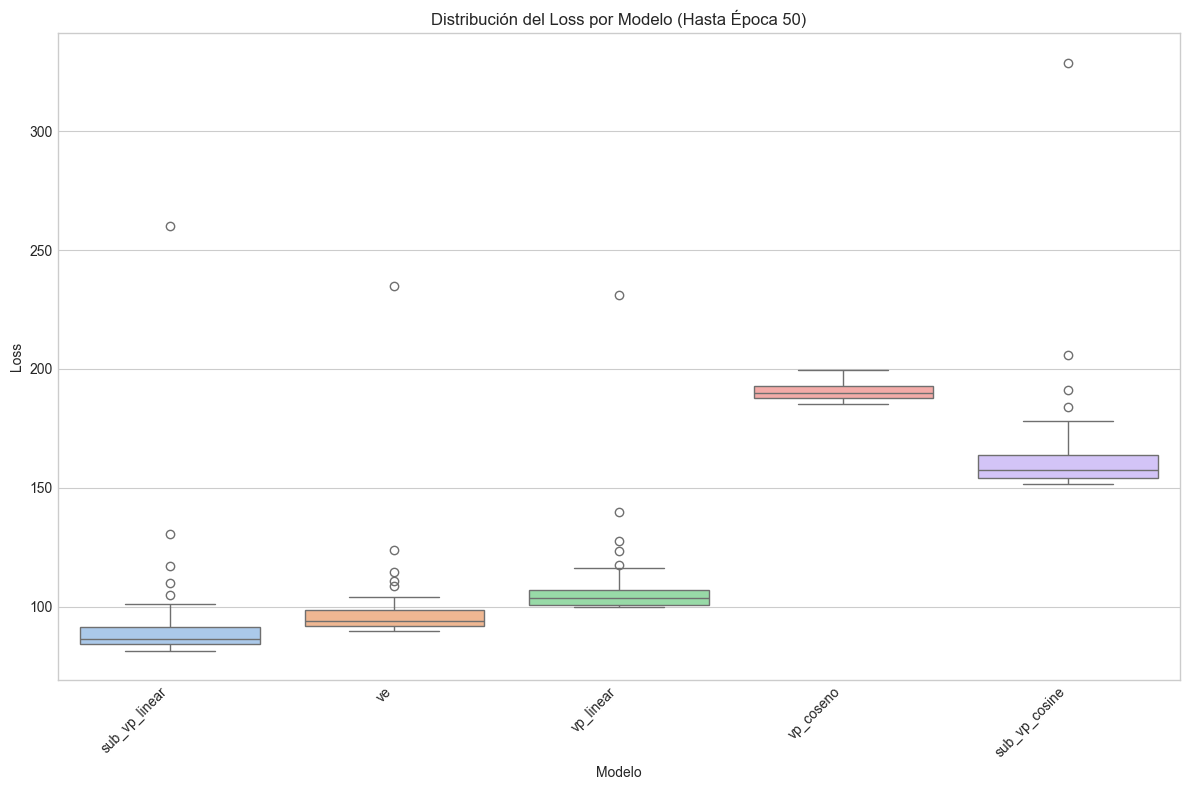

In [4]:
# --- 3. Boxplot Comparativo ---
if all_losses_for_boxplot:
    plt.figure(figsize=(12, 8))
    df_boxplot = pd.DataFrame({'Model': model_labels_for_boxplot, 'Loss': all_losses_for_boxplot})
    sns.boxplot(x='Model', y='Loss', data=df_boxplot, palette='pastel')
    plt.title(f'Distribución del Loss por Modelo (Hasta Época {epoch_limit})')
    plt.xlabel('Modelo')
    plt.ylabel('Loss')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()
else:
    print("No hay datos suficientes para generar el boxplot.")


C:\Users\loren\AppData\Local\Temp\ipykernel_16740\4060882000.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Model', y='Loss', data=df_boxplot, palette='Set3', inner='quartile')


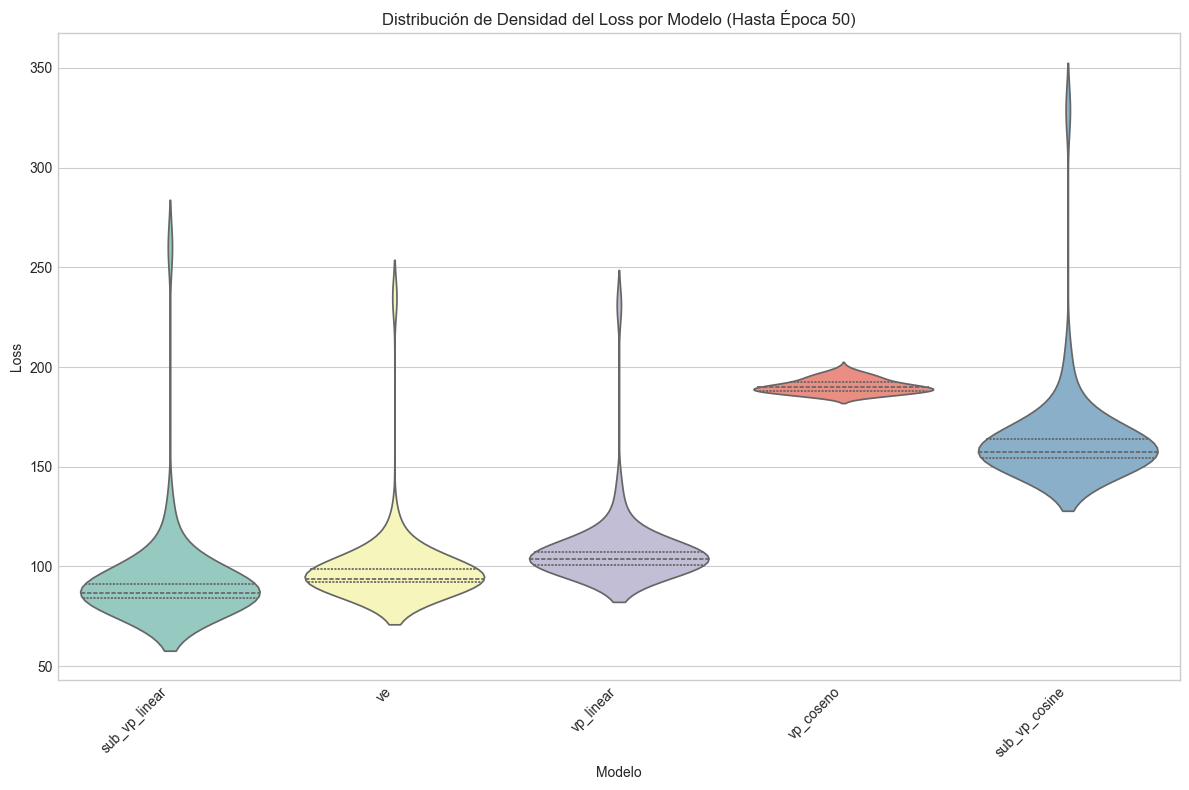

In [5]:
# --- 4. Violin Plot Comparativo ---
if all_losses_for_boxplot:
    plt.figure(figsize=(12, 8))
    sns.violinplot(x='Model', y='Loss', data=df_boxplot, palette='Set3', inner='quartile')
    plt.title(f'Distribución de Densidad del Loss por Modelo (Hasta Época {epoch_limit})')
    plt.xlabel('Modelo')
    plt.ylabel('Loss')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()
else:
    print("No hay datos suficientes para generar el violin plot.")

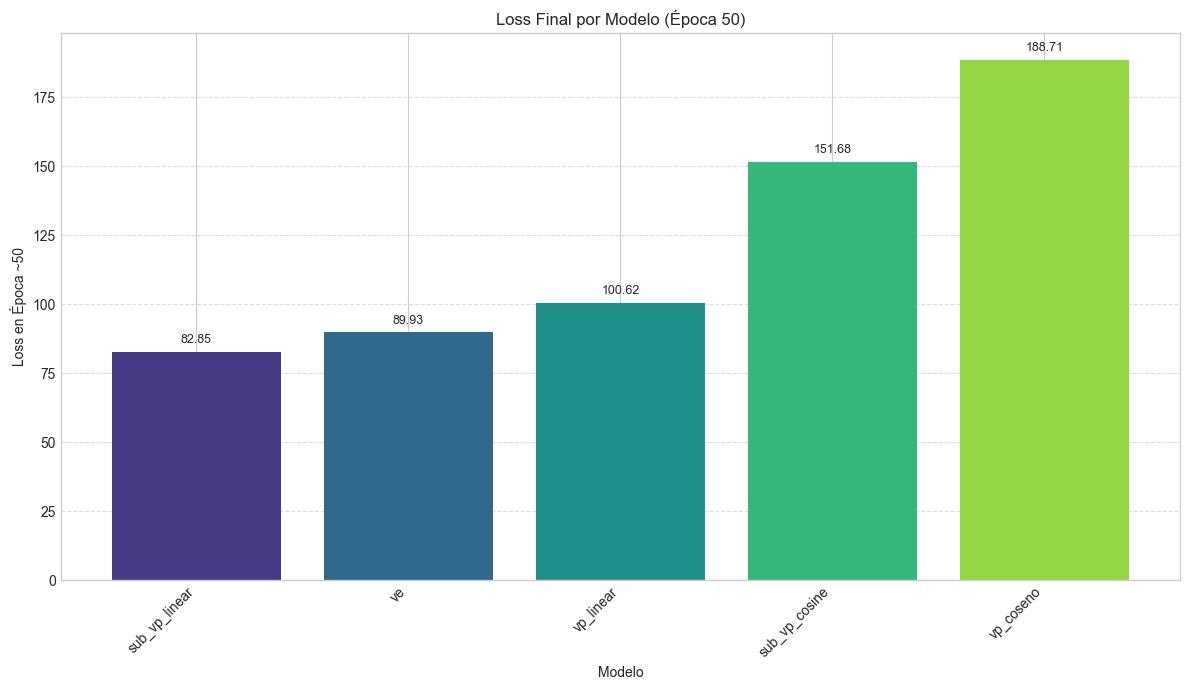

In [ ]:
# --- 5. Gráfica de Barras de Loss Final (Época 50) ---
# Filtrar NaNs antes de graficar
valid_final_losses = {k: v for k, v in final_losses.items() if not np.isnan(v)}
if valid_final_losses:
    sorted_final_losses = dict(sorted(valid_final_losses.items(), key=lambda item: item[1]))
    models_sorted_final = list(sorted_final_losses.keys())
    losses_sorted_final = list(sorted_final_losses.values())

    plt.figure(figsize=(12, 7))
    bars = plt.bar(models_sorted_final, losses_sorted_final, color=sns.color_palette("viridis", len(losses_sorted_final)))
    plt.title(f'Loss Final por Modelo (Época {epoch_limit})')
    plt.xlabel('Modelo')
    plt.ylabel(f'Loss en Época ~{epoch_limit}')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01 * max(losses_sorted_final), f'{yval:.2f}', ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("No hay datos de loss final válidos para graficar.")

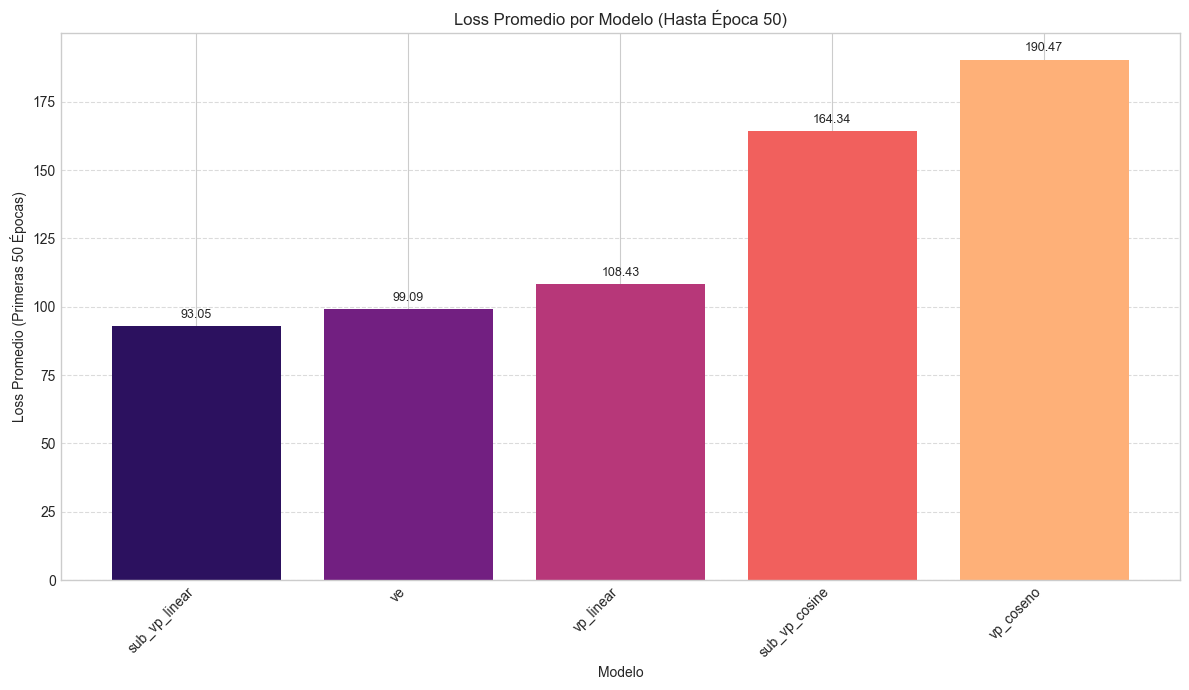

In [7]:


# --- 6. Gráfica de Barras del Loss Promedio (Hasta Época 50) ---
valid_average_losses = {k: v for k, v in average_losses.items() if not np.isnan(v)}
if valid_average_losses:
    sorted_avg_losses = dict(sorted(valid_average_losses.items(), key=lambda item: item[1]))
    models_sorted_avg = list(sorted_avg_losses.keys())
    losses_sorted_avg = list(sorted_avg_losses.values())

    plt.figure(figsize=(12, 7))
    bars = plt.bar(models_sorted_avg, losses_sorted_avg, color=sns.color_palette("magma", len(losses_sorted_avg)))
    plt.title(f'Loss Promedio por Modelo (Hasta Época {epoch_limit})')
    plt.xlabel('Modelo')
    plt.ylabel(f'Loss Promedio (Primeras {epoch_limit} Épocas)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01 * max(losses_sorted_avg), f'{yval:.2f}', ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("No hay datos de loss promedio válidos para graficar.")

In [ ]:
# --- 7. Tabla Resumen en Consola ---
print("\n--- Resumen de Losses ---")
summary_df = pd.DataFrame({
    'Loss Final (Época ~50)': pd.Series(final_losses),
    f'Loss Promedio (Hasta Época {epoch_limit})': pd.Series(average_losses)
})
summary_df = summary_df.sort_values(by=f'Loss Promedio (Hasta Época {epoch_limit})') # Ordenar por promedio
print(summary_df.round(4))


--- Resumen de Losses ---
               Loss Final (Época ~50)  Loss Promedio (Hasta Época 50)
sub_vp_linear                 82.8498                         93.0481
ve                            89.9330                         99.0857
vp_linear                    100.6188                        108.4281
sub_vp_cosine                151.6828                        164.3396
vp_coseno                    188.7054                        190.4677

¡Gráficas comparativas generadas!
